# Summary 


### Related literature


| Paper | Story | difference |
|:---------|:--------|:---------|
|  Kollmannsberger et al. 2007 and 2010 | Magnetic tweezer in an angle with power law based force control | Equation for was experimentally derived, power law, or when too close moved the solenoid. |
|  Chang et al. 2010a and 2010b  |  Quadrapolo magnetic tweezers with core connecting yoke. Introduced a force feedback based on the magnetic reluctance and considered ends as sharp point sources. Also another paper about its digital feedback system |  Sample area extremely small and tips were sharp. Not used for biomaterials and derivation a bit weird. |
| Ostrofet et al. 2018   |  Magnets on top of the sample to pull up the beads. record the bead position in z  | No analytical model for the force and meant for single molecule measurements.   |
| Kah et al. 2018 |  Magnetic tweezer in an angle with power law based force control. Instead feedback based on the current, they used hall sensor and magnetic field.  | No analytical model for the force. Empirically defined power law  |
| Lin 2012 | Circular core, analytical using bio-savart's law | Circular loop and bidirectional force |
| Moghram et al 2021 | One coil in an angle. Analytical formulation, B-based on sensor measurement. B based feedback | Analytical model to B level but not continued as function of i |
| Fisher et al 2006 | three coils with sharp ends, based on the simualtion |   |

## Motivation of the study

### In bullet points

- Previous works either increase magnetic fields or particle size to increase force on the particle. Either of these are adjusted during a measurement. \
    $\rightarrow$ Estimated average viscoelasticy and hereogenity are readily biased \
    $\Rightarrow$ In the work the force acting on the bead is adjusted during the measurement
- Theoretical model rarely apply directly to real world devices \
    $\rightarrow$ Incorrect force adjustment \
    $\Rightarrow$ Use physics-informed ML taught with calibration data to tune the adjustment values 
- Classical microrheological models describe materials with springs and dash-pots \
    $\rightarrow$ Models have bad explainability and often dont provide frequency dependent response  \
    $\Rightarrow$ Use equation to derive generalized response

### Novelty

Real-time machine learning supported force control to improve the accuracy of the state of art microrheology and expand current limitations.

### Introduction/Abstract

Hydrogels derived from biologically relevant sources serve as essential $\text{in vitro}$ 3D models, often referred as 3D cell culture matrices. Traditionally, the viscoelastic properties of these hydrogels are assessed using rheometers or microrheological techniques. While rheological tools offer valuable insights into the macroscopic mechanical behavior of materials. Biological applications demand a deeper understanding of microscale viscoelasticity and its spatial distribution. Given that cells themselves are microscale entities, elucidating microscale structural and viscoelastic cues becomes vital. These cues not only influence cellular functions but also play a crucial role in aberrant conditions such as cancer progression. Consequently, the development of precise tools for characterizing viscoelastic properties assumes paramount importance.

Microrheology has emerged as a potent technique for probing microscale viscoelasticity within samples. It enables measurements deep within the sample, facilitating compatibility with live-cell experiments while ensuring minimal perturbation to the sample. Moreover, microrheology empowers researchers to apply substantial forces, up to tens of nanonewtons, to magnetic particles, allowing for the assessment of samples spanning a wide range of Young's modulus, from approximately 10 to 10kPa. Notably, this range encompasses the entire spectrum of breast cancer viscoelasticity, from its benign to malignant invasive phases.

However, generating larger forces in a precisely controlled manner poses challenges. Enhancing force requires adjustments to the magnetic field, its gradient, or the characteristics of the beads or probes, each option presenting its own set of limitations. Non-linear spatial decay in magnetic fields and gradients introduces variability in applied forces across the sample during measurements, compromising throughput and limiting maximal strains. The effects are exacerbated with increased magnetic field or gradient strengths. Altering particle size or material further complicates measurements, potentially affecting the microenvironment and interactions with the surrounding matrix. These drawbacks, while not immediately evident during measurements, contribute to deviations in data, impacting the accuracy of calculated values and complicating heterogeneity mapping.

To mitigate these challenges, magnetic fields and gradients can be effectively modeled. However, real-world systems may deviate from theoretical expectations, necessitating corrections through physics-informed machine learning approaches based on calibration datasets. These modeled fields enable precise adjustments to forces acting on particles during measurements, facilitating the computation of accurate viscoelastic properties. Consequently, finer point-wise values can be obtained to map spatial variations with increased precision, while the assumption of constant magnetic field and gradient no longer imposes constraints on maximal strain application to materials.


 ## What was done

The project consists of 3 phases; First, make a new hardware codes to drive microrheometer with sufficient speed and accesibilty to include models for force adjustment. Secondly, redesign table, sample holder, and coil holder to decouple sample manipulation from coils. Thirdly, code new analysis pipe.

1) Hardware
    - Main thread: 
        - Qthreading and management
        - interface
        - Signaling with Qt slot and signal functions
        - Video saving (ffmpeg)
    - Sub-thread: Camera (pyPylon)
        - Acquire images
        - tracking
    - Sub-thread: Ni-DAQ unit (niDaqmx)
        - sampling coil current and magnetic field sensor
        - Output current contol via PID (B and I feedback separate)
    - Sub-thread: Model 
        - Aquire coordinates from the tracker, locate the bead, and calculate adjustment value
2) Coil design
    -Coil fixed on table in an angle with hall-sensor pocket. Sample holder moves with manual manipulator.
    <center><img src = "./figures/holder.png"  width="550" height="340"></center>
3) Analysis Pipe
    - Steps in analysis pipe
        1) Derive particle displacement in 2D and match camera timestamps with hardware timestamps
            - Displacement in spherical coordinantes where origo locates at infinitely far behind the core
                $\rightarrow$ only r-component is significant
        2) Compute theoretical fields and forces in the plane
            - Magnetic field: Comsol simulation using Gaussian quadrature loop technique (<a href="https://www.sciencedirect.com/science/article/pii/S0168900222002455">Granum 2022</a>).
            - Magnetization: Measure B-H curve for particles which follow Fröhlich-Kennelly function
            - Empirical force: Stoke's equation (silicon oil)
        3) Viscoelastic values
            - Micromechanical models (spring and dash-pot)
                - Separate creep and recovery
                - Simultaneous creep and recovery
            - Generalized Maxwell
        

# Results

1) Hardware performance
    - I-feedback works correct. 
    - B-feedback resonating $\rightarrow$ requires tuning 
    
<center><img src = "./figures/fits_hardware.png"  width="950" height="720"></center>

2) Analysis
    - Calibration tested with silicone oil and compared to simulation
        - Fields have similar shapes and absolute values

<center><img src = "./figures/forces.png" ></center>

3) Microrheology

- Creep-recovery experiments tested with growdex

    - Micromechanical models

<center><img src = "./figures/microns.png" ></center>

    - Generalized fits give impossible values (This with silicone oil)

<center><img src = "./figures/microns_2.png" ></center>

# ToDo list (Next)

- Hardware
    - [ ] Coil angle compensation
    - [ ] Test compensation field with measurements
    - [ ] Implement correction field
- Simulations and calculations
    - [ ] Measure 10µm bead magnetization curve
    - [ ] Measure 10µm bead density
    - [ ] particle trajectory simulations
    - [ ] Maximal strains from physics
    - [ ] Generalized fit with collagen

    - [ ] Read about plasticity and can it be included?
- Microrheology
    - Perform new measurements:
        - [ ] silicone oil
        - [ ] collagen 
        - [ ] Something else?
    - [ ] Demo for position feedback
    - [ ] General fit to GrowDex


# OneCoil project Notebook

## Theory

The derivation is mostly based on the book Microrheology by M. Furst and T. Squires. Here, we focus on 2D problem since microscope FoV limits observations to 2D projections.

he force experienced by a magnetic bead in an external non-homogeneous magnetic field overlaid with a gradient current $\nabla B$ is given by:

\begin{equation}
F_{\text{bead}} = V \cdot M(B) \cdot \nabla B(x,y)
\end{equation}

### Volume, V

The volume of the particle is determined by acquiring a z-stack over the particle volume and determining the largest cross-section of the particle using Laplacian variance. (<a href="https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv//">OpenCV blog</a>)

### Magnetic field, B

The magnetic field $B$ depends directly on the current $i$ linearly or non-linearly depending on the core properties and the magnitude of the current. Assuming constant core permeability gives a linear dependence between $B$ and $i_{\text{input}}$, whereas empirically measured B-H curve-based core permeability suggests non-linear dependence, which saturates at higher current magnitudes. Calculations are based on the core magnetization curve provided by the manufacturer.

$B$ was simulated using Comsol and Gaussian current loop technique (<a href="https://www.sciencedirect.com/science/article/pii/S0168900222002455">Granum 2022</a>). Simulations were performed using Comsol time-dependent module with a 0.5 A step wave. $\nabla B_x$ and $\nabla B_y$ were calculated from the obtained $B$. The spatial density of the simulation was 0.05 mm ($\partial x = \partial y = 5 \times 10^{-5}$), and geometry was defined assuming rotational symmetry as in cylindrical coordinates. (<a href="https://pubs.acs.org/doi/full/10.1021/acsami.5b06937"> Pokki et al 2015</a>)

\begin{align}
|B| &= \sqrt{B_x^2 + B_y^2} \\
\nabla B_x &= \frac{\partial |B|}{\partial x} \\
\nabla B_y &= \frac{\partial |B|}{\partial y}
\end{align}

$M(B)$ can be derived from magnetization measurements, which provide the magnetic moment ($m$) as a function of magnetic field intensity ($H$). The collected experimental data can be fitted using the Fröhlich-Kennelly function.

\begin{equation}
B = \left(\frac{1}{X_0} + \frac{|H|}{M_{\text{sat}}}\right)^{-1}
\end{equation}

where $X_0$ is magnetic susceptibility and $M_{\text{sat}}$ is saturation magnetization.

Due to the magnetic moment ($m$) measurement methods, volumetric magnetization was calculated via mass magnetization specifying individual values for each particle using density, $\rho$.

\begin{align}
M_{\text{mass}} &= \frac{m}{\text{mass}} \\
M_{\text{volumetric}} &= M_{\text{mass}} \cdot \rho
\end{align}

### Empirical Force

On the other hand, force can also be determined empirically using Stokes' law:

\begin{equation}
F_{\text{Stokes}} = 6 \pi R \eta v
\end{equation}

where $R$ is the bead radius, $\eta$ is viscosity, and $v$ is bead velocity.

### Simulation 

Similar assumptions as in the Stokes-Einstein relation were considered to be valid (<a href="https://www.annualreviews.org/doi/pdf/10.1146/annurev-fluid-121108-145608">Squires 2010</a>) . Note: It is expected that some of the assumptions breakdown as discussed in the paper. However, these do not make the calculations invalid; the interpretation just changes, and the results cannot be directly compared, for instance, with macroscale data.

A displacement model to estimate particle trajectories and total forces acting on particles was done assuming Eq.1 and no resistance from the medium.

- $k$ - number of timesteps
- $dt$ - length of timestep
- $\rho$ - density
- $s_{k, \text{bead}}$ - bead position
- $v_{k, \text{bead}}$ - bead velocity

\begin{align}
f_{\text{tot}} &= f_{\text{bead}} \\
v_{k, \text{bead}} &= \frac{f_{\text{bead}}}{m} \cdot dt \\
s_{k, \text{bead}} &= s_{k-1, \text{bead}} + v_{k, \text{bead}} \cdot dt
\end{align}

Due to viscoelastic nature of the material. We assume that moment of the bead faces resistance from the material according to differential equation 

Lets derive step-weise resistance where the force acting on the particle is considered constant during each step. The stepping rate equals to sampling rate

\begin{align}
6 \pi r \eta \frac{\partial x}{\partial t} + 6 \pi r \mu x &= f(t) \\
\frac{F}{A} &= \frac{\partial x}{\partial t} + \frac{B}{A}*x
\end{align}

We recognize 1. order non-homogenous ODE which can be solved using variation of parameters $x(t) = g(t) + h(t)$. $\tau$ representsa the length of the step. 

\begin{align}
P(t) &= \int - p(t) dt = - \frac{B \cdot \tau }{A} \\
v'(t) &= e^{-P(t)} \cdot f(t) = e^{\frac{B \cdot \tau }{A}} \cdot F \\
v(t) &=  \int e^{\frac{B \cdot \tau }{A}}*F dt = F \cdot \frac{A}{B \cdot \tau} e^{\frac{B \cdot \tau }{A}} \\
x(t) &= F \frac{A}{B \cdot \tau} e^{\frac{B \cdot \tau }{A}} e^{\frac{Bt}{A}} + C e^{\frac{Bt}{A}}
\end{align}

At $t=0$ of each step, the bead is in the previous location $x_{k-1}$

\begin{align}
x(t=0) &= x_{k-1} \\
F \frac{A}{B \cdot \tau} e^{\frac{B \cdot \tau }{A}} e^{\frac{Bt}{A}} + C e{\frac{Bt}{A}} &= x_{k-1} \\
t &= 0 \\
F \frac{A}{B \cdot \tau} e^{\frac{B \cdot \tau }{A}} + C &= x_{k-1} \\
C &= x_{k-1} - F \frac{A}{B \cdot \tau} e^{\frac{B \cdot \tau }{A}} \\
\end{align}

Then collect it together and also transform to a discrete format since the problem was linearlized stepwise.

\begin{align}
s_{k, \text{bead}} = x(t) = x_k &= (\alpha + \beta)*e^{\frac{B*t}{A}} \\
\alpha &= F_k \frac{A}{B \cdot \tau} e^{\frac{B \cdot \tau }{A}} \\
\beta &= x_{k-1} - F \frac{A}{B \cdot \tau} e^{\frac{B \cdot \tau }{A}}
\end{align}

Which replaces the position equation in the previous equation.

## Analysis

Mechanical parameters were derived from simulated and experimental displacement data using 1) micromechanical models and 2) generalized response (<a href="https://journals.aps.org/pre/pdf/10.1103/PhysRevE.80.012501"> derivation in Evans et al </a>). Without B adjustment, moving beads do not experience constant magnetic gradient since non-homogeneous B. However, if the displacements are small, constant force is a valid assumption.

One of the aims of this work is to compare how much this assumption affects the final results.

## Micromechanical models

Micromechanical models tested here include Maxwell, Kelvin-Voigt, Burger, and Weibull models. The Burger model often fits the best and is demonstrated in this document.

### Creep:

Burger model:

\begin{equation}
\epsilon_{\text{Burger's}} (t) = \sigma \left( \frac{1}{E_1} + \frac{t}{n_1} + \frac{1}{E_2} (1 - e^{ - \frac{E_2 t}{n_2}}) \right)
\end{equation}

### Recovery:

Burger model:

\begin{equation}
\epsilon_{\text{Burger's}} (t) = \frac{t_c}{n_1} \left(1 - e^{- \frac{t-t_c}{\frac{n_2}{E_2}}} + \frac{1}{E_1} e^{- \frac{t-t_c}{\frac{n_2}{E_2}}}\right)
\end{equation}

### Generalized response

\begin{align}
G'(\omega) + i G''(\omega) &= \frac{i \omega}{ i \omega J (0) + \dot{J}(0) + \mathscr{F}J_2} \\
\frac{i \omega}{G^*(\omega)} &= i \omega J(0) + (1-e^{-i \omega t_1}) \frac{J_1 - J(0)}{t_1} + \frac{e^{-i \omega t_N}}{\eta} + \sum_{k=2}^{N} \left( \frac{J_k - J_{k-1}}{t_k - t_{k-1}} \right) (e^{-i \omega t_{k-1}} - e^{-i \omega t_k}) \
J(t) &= \frac{\gamma}{\sigma} = \frac{\Delta x /(2r)}{F_{\text{bead}}/(\pi r^2)}
\end{align}

$J(0)$ and $\eta$ can also be derived from the fit:

\begin{equation}
J(t) = \frac{t}{\eta} + a + b \cdot \tanh(c+d \cdot \ln(t)+e \cdot \ln^2(t) + f \cdot \ln^3(t))
\end{equation}




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os 

import _pickle as cPickle
from glob import glob

import json

import scipy
from scipy.optimize import curve_fit

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# Hardware performance

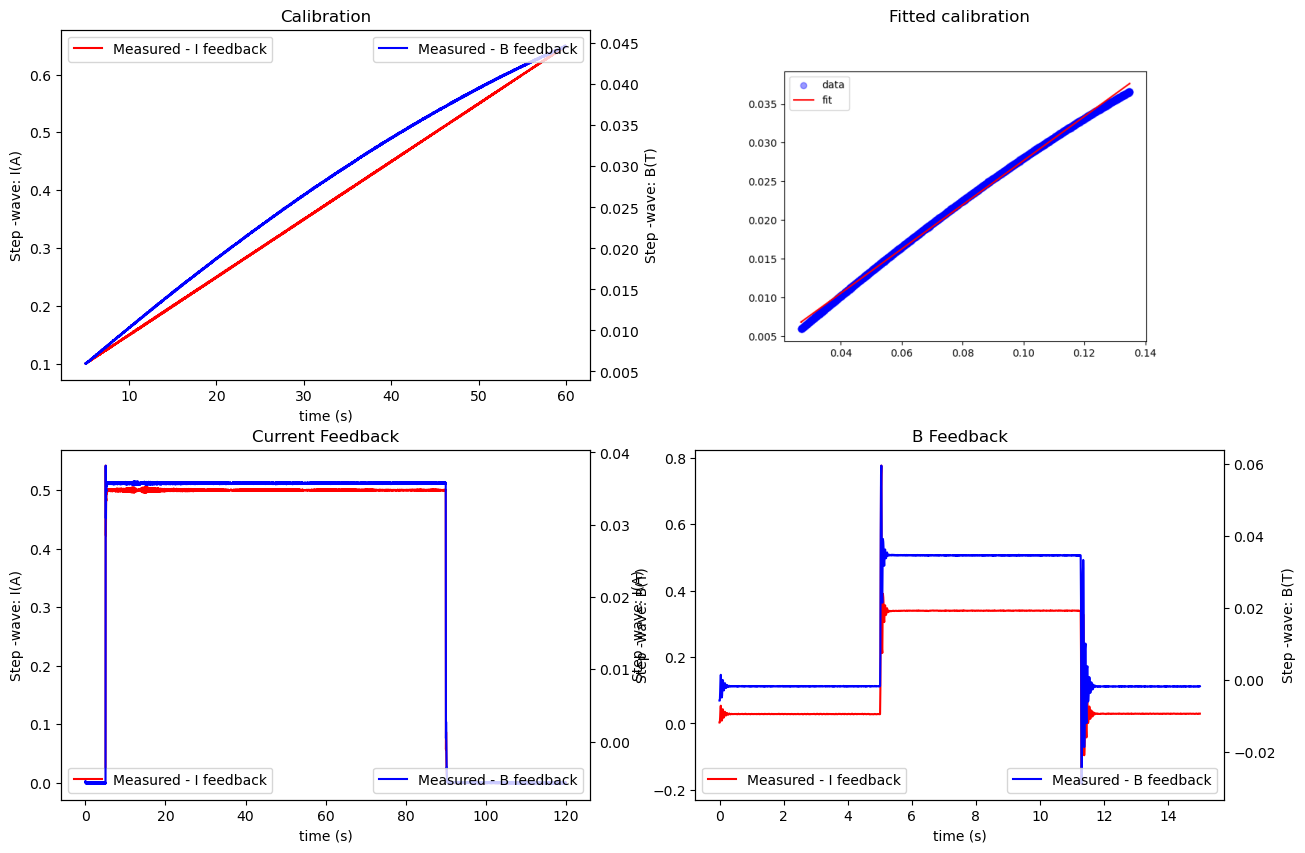

In [3]:
fig, ax  = plt.subplots(2, 2, figsize = (15,10))

#Load calibration
path_calib = "E:/demoData/calib/calib_2024-02-01.npy"
df_calib = pd.DataFrame(np.load(path_calib).T, columns = ['index','aim','measured','Mg', 'scaler'])

start = 500
end = 6000

ax[0,0].set_title("Calibration")
ax1 = ax[0,0].twinx()

ax[0,0].plot(df_calib["index"][start:end],df_calib["measured"][start:end], color = "red", label = "Measured - I feedback")
ax1.plot(df_calib["index"][start:end],df_calib["Mg"][start:end], color = "blue", label = "Measured - B feedback")

ax[0,0].set_ylabel("Step -wave: I(A)")
ax[0,0].set_xlabel("time (s)")
ax1.set_ylabel("Step -wave: B(T)")

ax[0,0].legend(loc = "upper left")
ax1.legend(loc = "upper right")

#Calibration fit
ax[0,1].set_title("Fitted calibration")
img = cv2.imread("E:/demoData/calib/calib_2024-02-01.png")
ax[0,1].imshow(img)
ax[0,1].axis("off")

#Load current feedback
path_current = "E:/demoData/current_1/driver_2024-02-01.npy"
df_current = pd.DataFrame(np.load(path_current).T, columns = ['index','aim','measured','Mg', 'scaler'])

ax[1,0].set_title("Current Feedback")
ax2 = ax[1,0].twinx()

ax[1,0].plot(df_current["index"],df_current["measured"], color = "red", label = "Measured - I feedback")
ax2.plot(df_current["index"],df_current["Mg"], color = "blue", label = "Measured - B feedback")

ax[1,0].set_ylabel("Step -wave: I(A)")
ax[1,0].set_xlabel("time (s)")
ax2.set_ylabel("Step -wave: B(T)")

ax[1,0].legend(loc = "lower left")
ax2.legend(loc = "lower right")

#Load current feedback
path_B = "E:/demoData/B_3/driver_2024-02-01.npy"
df_B = pd.DataFrame(np.load(path_B).T, columns = ['index','aim','measured','Mg', 'scaler'])

ax[1,1].set_title("B Feedback")
ax3 = ax[1,1].twinx()

ax[1,1].plot(df_B["index"],df_B["measured"], color = "red", label = "Measured - I feedback")
ax3.plot(df_B["index"],df_B["Mg"], color = "blue", label = "Measured - B feedback")

ax[1,1].set_ylabel("Step -wave: I(A)")
ax[1,1].set_xlabel("time (s)")
ax3.set_ylabel("Step -wave: B(T)")

ax[1,1].legend(loc = "lower left")
ax3.legend(loc = "lower right")

fig.savefig('./figures/fits_hardware.png') 

# Theory 

In [4]:
def calc_force(data):

    radius = 5.5e-6
    T_0 = 25
    r_T_0 = 0.971e3
    v = 1000e-6

    # our experiments
    T = 23
    a = 9.2e-4
    b = 4.5e-7
    r = r_T_0/(1+a*(T-T_0)+b*(T-T_0)**2)
    nn = v*r


    v_fit = np.abs(data)
    F_fit = 6*np.pi*nn*radius*v_fit

    return F_fit

def func(x, a, b):
    return a*np.tanh(x*b)

def func_Fk(x, x_0, H_sat):
    return x/(1/x_0 + np.abs(x)/H_sat)

def G(omega, J0, n, sum, t1, J1, t_last):
    j=1j
    return j*omega*J0 + (1-np.exp(-j*omega*t1))*(J1-J0)/t1 + np.exp(-j*omega*t_last)/n + sum

def J_t(t, eta, a, b, c, d, e, f):
    return (t/eta) + a + b*np.tanh(c + d*np.log(t) + e*np.log(t)**2 + f*np.log(t)**3)

def kelvin(t,tau,D):
    return D*(1-np.exp(-t/tau))

def maxwell(t, D, tau):
    return D*(1+t/tau)

def maxwell_rel(t, E, tau ):
    return E*np.exp(-t/tau) 

def burger_model(x, E_1, E_2, n_1, n_2):
    return 1/E_1 + x/n_1 + 1/E_2*(1-np.exp(-x*E_1/n_2))

def burger_rel(x, E_1, E_2, n_1, n_2):
    t_c = 1
    return t_c/n_1*(1- np.exp(-(x-t_c)/(n_2/E_2))) + (1/E_1)*np.exp(-(x-t_c)/(n_2/E_2))

def Weibull_creep(x, e_i, e_c, beta, tau):
    return e_i + e_c*(1-np.exp(-(x/tau)**beta))

def Weibull_rel(x, e_r, e_f, beta, tau):
    return e_f + e_r*(np.exp(-(x/tau)**beta))

class stateSpace():

    def __init__(self, x_coord, y_coord, B, dBx, dBy, M, H, mu_0):
        self.B_field = B
        self.dBx_field = dBx
        self.dBy_field = dBy

        self.M_slope = M
        self.H_slope = H
        self.x_sim = x_coord
        self.y_sim = y_coord

        self.mu_0 = mu_0
    
    def find_force(self, x, y, radius):

        x_idx = np.argmin(np.abs((self.x_sim-x)))
        y_idx = np.argmin(np.abs((self.y_sim-y)))

        B_current = self.B_field[y_idx, x_idx]
        H_current = B_current/self.mu_0

        mu_idx = np.argmin(np.abs(self.H_slope - H_current))
        mu_current = self.M_slope[mu_idx]

        F_field_x = 4/3*np.pi*(radius)**3*mu_current*self.dBx_field[y_idx,x_idx] #Estimate
        F_field_y = 4/3*np.pi*(radius)**3*mu_current*self.dBy_field[y_idx,x_idx] #Estimate

        force =  np.sqrt((F_field_x)**2 + (F_field_y)**2)

        return force


## Define configs

In [5]:
root = "E:/demoData"

#Configs
ni_rate = 100 #NI acquisition rate
camera_rate = 40 #Camera acquisition rate
rate_rate = ni_rate/camera_rate #Ratio between acquisitions

m = 3.5/(10*0.3*2.6) #Pixel size

#Find starting and stopping index
start = int(500/rate_rate)
end = int(1150/rate_rate)


radius = 5.5e-6 #Bead size m
rho = 1.3 * 1000 #Bead density kg/m^3

mu_0 = 4*np.pi*1e-7 #permeability

height = 1544*m*1e-6 #height of FoV in µm
width = 2064*m*1e-6 #width of FoV in µm

#Parameters to crop simulation
start_w =  0.0035 - width 
end_w = 0.0035
start_h = 0.003 - height/2
end_h = 0.003 + height/2


#Download frame for visualization glitter
path_vid = glob(os.path.join(root,"track_5/*.mp4"))
cap = cv2.VideoCapture(path_vid[0])
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        #frame = cv2.flip(frame,0)
        break


## Calculate particle magnetization

In [6]:
paths = glob(os.path.join(root,"resource/*.dat"))


for count,i in enumerate(paths):
    ending = i.split("\\")[-1]
    parts = ending.split("_")
    day = parts[0]
    weight = float(parts[2][:-6])*1e-8 #*0.0275

    df_sub = pd.read_csv(i, sep= ",", skiprows = np.arange(0,31)).iloc[1:, :].dropna(how='all', axis = "columns")
    df_sub["sample"] = count
    df_sub["weight"] = weight

    #Oe  1/(4pi)*10^3 A/m
    df_sub["H"] = df_sub["Magnetic Field (Oe)"] * 1/(4*np.pi)*1e3
    #= 1 emu 10−3 A·m2
    df_sub["moment"] = df_sub["Moment (emu)"]*1e-3

    start_sat = np.where(df_sub["H"][:125].values>600e3)[0][0]
    end_sat = np.argmax(df_sub["H"][:125].values)

    k = np.polyfit(df_sub["H"][start_sat:end_sat].values,df_sub["moment"][start_sat:end_sat].values-df_sub["moment"][start_sat:end_sat].values[0],deg = 1, cov = False)
    offset = k[0]*df_sub["H"]

    df_sub["moment"] = df_sub["moment"] - offset
    df_sub["M_mass"] = df_sub["moment"]/(weight)

    if count == 0:
        df_bead = df_sub
    else:
        df_bead = pd.concat((df_bead,df_sub))

df_bead["H_round"] = np.round(df_bead["H"].values, -5)
fd_mean = df_bead.groupby(["H_round"]).mean().reset_index()
mask = fd_mean["H"].values >= 0
xdata = np.linspace(0,800000,1000)
popt, pcov = curve_fit(func_Fk, fd_mean["H_round"][mask], fd_mean["M_mass"][mask], method = "dogbox", bounds = [[0,0],[10,np.inf]])
ydata = func_Fk(xdata, *popt)

M_mag = ydata*rho
B_mag = xdata*mu_0

## Calculated magnetic field and its gradient

In [7]:

df_sim = pd.read_csv(os.path.join(root, "resource/One_coil.csv"), sep = ",", skiprows= [0,1], names = ["x", "y", "By", "Bx"])
df_sim["Bx"] = scipy.ndimage.gaussian_filter1d(df_sim["Bx"].values,5) 
df_sim["By"] = scipy.ndimage.gaussian_filter1d(df_sim["By"].values,5)
df_sim["x"] = np.round(df_sim["x"], 5) #- (0.0035 - width)
df_sim["y"] = np.round(df_sim["y"], 5) #- (0.003 - height/2)

df_sim["B"] = np.sqrt((df_sim["Bx"].values)**2 +  df_sim["By"].values**2)
B = df_sim["B"].values

map_x = df_sim["x"].values
map_y = df_sim["y"].values


xx__ = np.linspace(start_w,end_w, frame.shape[1]) #- (0.0035 - width)
yy__ = np.linspace(start_h,end_h, frame.shape[0]) #- (0.003 - height/2)

test_frame = 255-cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
phase = 5

y_unique = np.unique(map_y) 
x_unique = np.unique(map_x) 
y_u = len(np.unique(map_y))
x_u = len(np.unique(map_x))

y_coord = np.concatenate((x_unique, x_unique+np.max(x_unique)))
x_coord = y_unique
B = B.reshape((y_u, x_u))

BB = np.vstack((B.T[::-1,:], B.T))
filtered = scipy.ndimage.gaussian_filter(BB, 5)

dBy = scipy.ndimage.gaussian_filter(np.gradient(filtered, 1e-5, axis  = 1),5)#*np.sin(angle)
dBx = -scipy.ndimage.gaussian_filter(np.gradient(filtered, 1e-5, axis  = 0),5)#*np.cos(angle)

X1, Y1 = np.meshgrid(x_coord, y_coord)

## Download and parse tracking data

### Multiple files

In [8]:
path_multi_track = glob(os.path.join(root,"track_*/*.json"))

ref_flag = True
mg_flag = True

ref_label = 0
mg_label = 0 

for current_path in path_multi_track:

    with open(current_path, "rb") as input_file:
        file_dict = json.load(input_file)

    for i in file_dict.keys():
        parts = i.split("_")
        if parts[0] == "ref":
            if ref_flag:
                temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end][start:end].reset_index()
                temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
                temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
                df_ref = temp_df
                df_ref["label"] = ref_label
                ref_label += 1
                ref_flag = False
            else:
                temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
                temp_df["label"] = ref_label
                ref_label += 1
                temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
                temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
                df_ref = pd.concat((df_ref,temp_df))
            df_ref["type"] = "ref"
            #df_ref["label"] = parts[1]
        else:
            if mg_flag:
                temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
                temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
                temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
                df_mg = temp_df
                df_mg["label"] = mg_label
                mg_label += 1
                mg_flag = False
            else:
                temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
                temp_df["label"] = mg_label
                mg_label += 1
                temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
                temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
                df_mg = pd.concat((df_mg,temp_df))
            
            df_mg["type"] = "mg"
                #df_mg["label"] = parts[1]
            
df_mg["y_scaled"] = df_mg["y"]*1e-6*m + start_h
df_mg["x_scaled"] = df_mg["x"]*1e-6*m + start_w


### One file

In [5]:
path_multi_track = glob(os.path.join(root,"track_5/*.json"))
with open(path_multi_track[0], "rb") as input_file:
    file_dict = json.load(input_file)

for i in file_dict.keys():
    parts = i.split("_")
    if parts[0] == "ref":
        if parts[1] == "0":
            temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end][start:end].reset_index()
            temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
            temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
            df_ref = temp_df
            df_ref["label"] = parts[1]
        else:
            temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
            temp_df["label"] = parts[1]
            temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
            temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
            df_ref = pd.concat((df_ref,temp_df))
        df_ref["type"] = "ref"
        #df_ref["label"] = parts[1]
    else:
        if parts[1] == "0":
            temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
            temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
            temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
            df_mg = temp_df
            df_mg["label"] = parts[1]
        else:
            temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
            temp_df["label"] = parts[1]
            temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
            temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
            df_mg = pd.concat((df_mg,temp_df))
        
        df_mg["type"] = "mg"
            #df_mg["label"] = parts[1]
        
df_mg["y_scaled"] = df_mg["y"]*1e-6*m + start_h
df_mg["x_scaled"] = df_mg["x"]*1e-6*m + start_w

## Calculate theoretical and experimental forces

In [9]:
df_col = pd.DataFrame()

for tags,i in df_mg.groupby(["label"]):

    timer = 0

    i["v"] = scipy.ndimage.gaussian_filter(np.sqrt((np.gradient(i["x_scaled"])/(1/camera_rate))**2 + (np.gradient(i["y_scaled"])/(1/camera_rate))**2),5 )
    F = calc_force(i["v"].values) #Force from Stokes eq.
    i["F_stokes"] = F
    
    force_vector = np.zeros(len(i["x_scaled"].values))

    for x_pos, y_pos in zip(i["x_scaled"].values,i["y_scaled"].values):
                     
        x_idx = np.argmin(np.abs((x_coord-x_pos)))
        y_idx = np.argmin(np.abs((y_coord-y_pos)))

        B_current = BB[y_idx, x_idx]
        H_current = B_current/mu_0

        mu_idx = np.argmin(np.abs(xdata - H_current))
        mu_current = M_mag[mu_idx]

        F_field_x = 4/3*np.pi*(radius)**3*mu_current*dBx[y_idx,x_idx] #Estimate
        F_field_y = 4/3*np.pi*(radius)**3*mu_current*dBy[y_idx,x_idx] #Estimate

        force_vector[timer] =  np.sqrt((F_field_x)**2 + (F_field_y)**2)

        timer += 1

    i["force"] = force_vector
    
    if df_col.shape == 0:
        df_col = i
    else:
        df_col = pd.concat((df_col, i))
    count += 1

model_force = stateSpace(x_coord, y_coord, BB, dBx, dBy, M_mag, xdata, mu_0)

df_col["radius"]*=m

## Visualize theory

KeyboardInterrupt: 

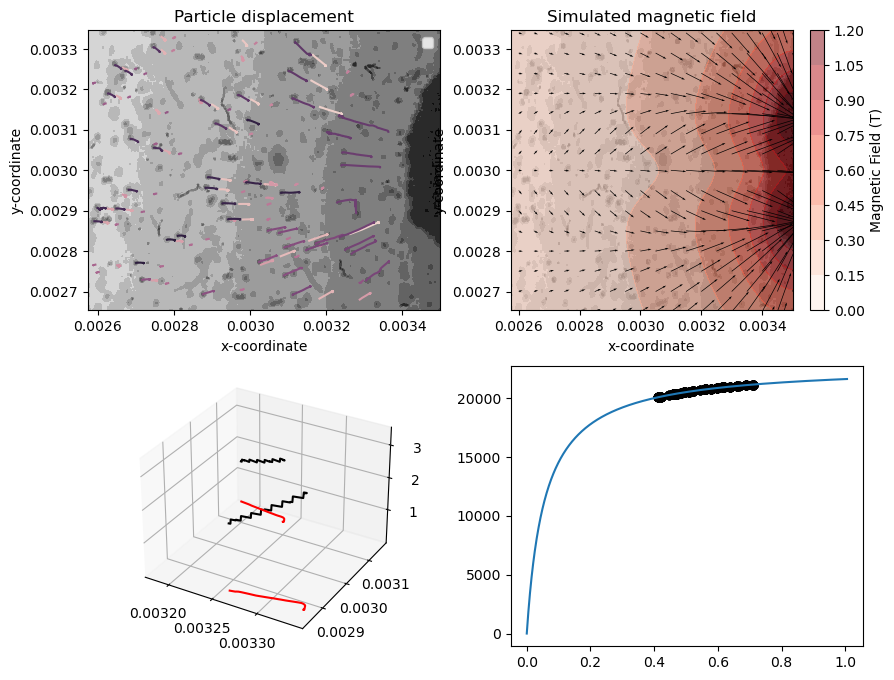

In [13]:
fig = plt.figure(figsize = (10,8))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3, projection='3d')
ax4 = fig.add_subplot(2,2,4)

ax2.contourf(xx__, yy__, test_frame, alpha = 1, cmap="binary")
CS = ax2.contourf(x_coord, y_coord, filtered, alpha = 0.5, cmap = "Reds")
ax2.quiver(X1[::phase, ::phase], Y1[::phase, ::phase], dBy[::phase,::phase], -dBx[::phase,::phase], angles = "xy") #dBy[::phase,::phase],dBx[::phase,::phase]
ax2.set_xlim([start_w,end_w])
ax2.set_ylim([start_h,end_h])

ax1.contourf(xx__, yy__, test_frame, alpha = 1, cmap="binary")
sns.lineplot(x = "x_scaled", y = "y_scaled", data = df_mg, hue = "label", ax = ax1)
ax1.legend([])

ax1.set_title("Particle displacement")
ax1.set_xlabel("x-coordinate")
ax1.set_ylabel("y-coordinate")

ax2.set_title("Simulated magnetic field")
ax2.set_xlabel("x-coordinate")
ax2.set_ylabel("y-coordinate")

cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Magnetic Field (T)')

ax4.plot(B_mag, M_mag)

for tags,i in df_col.groupby(["label"]):
    for x_pos, y_pos in zip(i["x_scaled"].values,i["y_scaled"].values):
                     
        x_idx = np.argmin(np.abs((x_coord-x_pos)))
        y_idx = np.argmin(np.abs((y_coord-y_pos)))

        B_current = BB[y_idx, x_idx]
        H_current = B_current/mu_0
        mu_idx = np.argmin(np.abs(xdata - H_current))

        ax4.scatter(B_mag[mu_idx], M_mag[mu_idx], color = "black")

    ax3.plot(i["x_scaled"],i["y_scaled"], i["F_stokes"], color = "red")
    ax3.plot(i["x_scaled"],i["y_scaled"], i["force"], color = "black") #scalin for visualization
    

ax4.set_title("Particle magnetization and sampled points")
ax4.set_xlabel("Magnetic field flux (T)")
ax4.set_ylabel("Magnetization (A/m)")

ax3.set_xlim([start_w,end_w])
ax3.set_ylim([start_h,end_h])

ax3.set_title("Simulated and empirical forces")
ax3.set_xlabel("x-coord (m)")
ax3.set_ylabel("y-coord (m)")
ax3.set_zlabel("Force (nN)")

plt.tight_layout()


#fig.savefig('./figures/forces.png') 

## Analysis

In [10]:
def kelvin(t,tau,D):
    return D*(1-np.exp(-t/tau))

def maxwell_creep(t, D, tau):
    return D*(1+t/tau)

def maxwell_rel(t, E, tau ):
    return E*np.exp(-t/tau) 

def burger_creep(x, E_1, E_2, n_1, n_2):
    return 1/E_1 + x/n_1 + 1/E_2*(1-np.exp(-x*E_1/n_2))

def burger_rel(x, E_1, E_2, n_1, n_2):
    t_c = 1
    return t_c/n_1*(1- np.exp(-(x-t_c)/(n_2/E_2))) + (1/E_1)*np.exp(-(x-t_c)/(n_2/E_2))

def Weibull_creep(x, e_i, e_c, beta, tau):
    return e_i + e_c*(1-np.exp(-(x/tau)**beta))

def Weibull_rel(x, e_f, e_r, beta, tau):
    return e_f + e_r*(np.exp(-(x/tau)**beta))

def fit_classicMicro(x, y, label, start, end, helper):

    #x -= x[0]
    #param = {}

    t_hat_creep = np.arange(x[start],x[end], 0.001)
    t_hat_rel = np.arange(x[end], x[helper], 0.001)

    x_creep = x[start:end] - x[start]
    x_rel = x[end:helper] - x[end]

    y_creep = y[start:end] - y[start]
    y_rel = y[end:helper] - y[start]

    xx = np.concatenate((x_creep, x_rel+x[end]-x[start]))
    yy = np.concatenate((y_creep, y_rel))

    if label == "Maxwell":
        p_creep, p_creep_e = curve_fit(maxwell_creep, x_creep, y_creep, method = "dogbox") 
        p_rel, p_rel_e = curve_fit(maxwell_rel, x_rel, y_rel, method = "dogbox")

        param = [p_creep, p_rel]

        ydata = np.concatenate((maxwell_creep(t_hat_creep,*p_creep), maxwell_rel(t_hat_rel-t_hat_rel[0],*p_rel)))
        xdata = np.concatenate((t_hat_creep, t_hat_rel))

    elif label == "Burger":
        p_creep, p_creep_e = curve_fit(burger_creep, x_creep, y_creep, method = "dogbox")
        p_rel, p_rel_e = curve_fit(burger_rel, x_rel, y_rel, method = "dogbox")

        param = [p_creep, p_rel]

        ydata = np.concatenate((burger_creep(t_hat_creep,*p_creep), burger_rel(t_hat_rel-t_hat_rel[0],*p_rel)))
        xdata = np.concatenate((t_hat_creep, t_hat_rel))

    elif label == "Weibull":
        p_creep, p_creep_e = curve_fit(Weibull_creep, x_creep, y_creep, method = "dogbox")
        p_rel, p_rel_e = curve_fit(Weibull_rel, x_rel, y_rel, method = "dogbox")

        param = [p_creep, p_rel]

        ydata = np.concatenate((Weibull_creep(t_hat_creep,*p_creep), Weibull_rel(t_hat_rel-t_hat_rel[0],*p_rel)))
        xdata = np.concatenate((t_hat_creep, t_hat_rel))

    ydata[0] = 0
    
    return xx, yy, xdata, ydata, param
    
class burger():

    def __init__(self, t_c, epsilon, start, end, helper):
        self.epsilon_0 = epsilon

        self.t_hat_creep = None
        self.t_hat_rel = None

        self.t_c = t_c
        self.end = end
        self.start = start
        self.helper = helper

        
    def burger_creep(self, x, E_1, E_2, n_1, n_2):
        return 1/E_1 + x/n_1 + 1/E_2*(1-np.exp(-x*E_1/n_2))
        
    def burger_rel(self, x,E_1, E_2, n_1, n_2):
        return self.t_c/n_1*(1-np.exp(-(x-self.t_c)*(E_2/n_2))) + (self.epsilon_0-1/E_1)*np.exp(-(x-self.t_c)*(E_2/n_2))
    
    def combined(self, x_tot, E_1, E_2, n_1, n_2):
        # single data reference passed in, extract separate data

        extract1 = x_tot[:self.end-self.start] # first data
        extract2 = x_tot[self.end-self.start:] # second data

        result1 = self.burger_creep(extract1, E_1, E_2, n_1, n_2)
        result2 = self.burger_rel(extract2, E_1, E_2, n_1, n_2)

        return np.append(result1, result2)
    
    def fit(self, x, y):

        x_ = x[self.start:self.helper]-x[self.start]
        y_ = y[self.start:self.helper]-y[self.start]

        self.t_hat_creep = np.arange(x[start], x[end], 0.001) - x[self.start]
        self.t_hat_rel = np.arange(x[end], x[self.helper], 0.001) - x[self.start]

        p, pcov = curve_fit(self.combined, x_, y_, maxfev = 100000)

        yy_creep = self.burger_creep(self.t_hat_creep,*p)
        yy_rel = self.burger_rel(self.t_hat_rel,*p) 

        xx = np.concatenate((self.t_hat_creep, self.t_hat_rel))

        yy = np.concatenate((yy_creep, yy_rel))

        yy[0] = 0

        return xx, yy, p
    
label_list = ["Maxwell", "Kelvin-Voigt", "Burger", "Weibull"]

### Micromechanical models: fit in two-phases and in one-phase

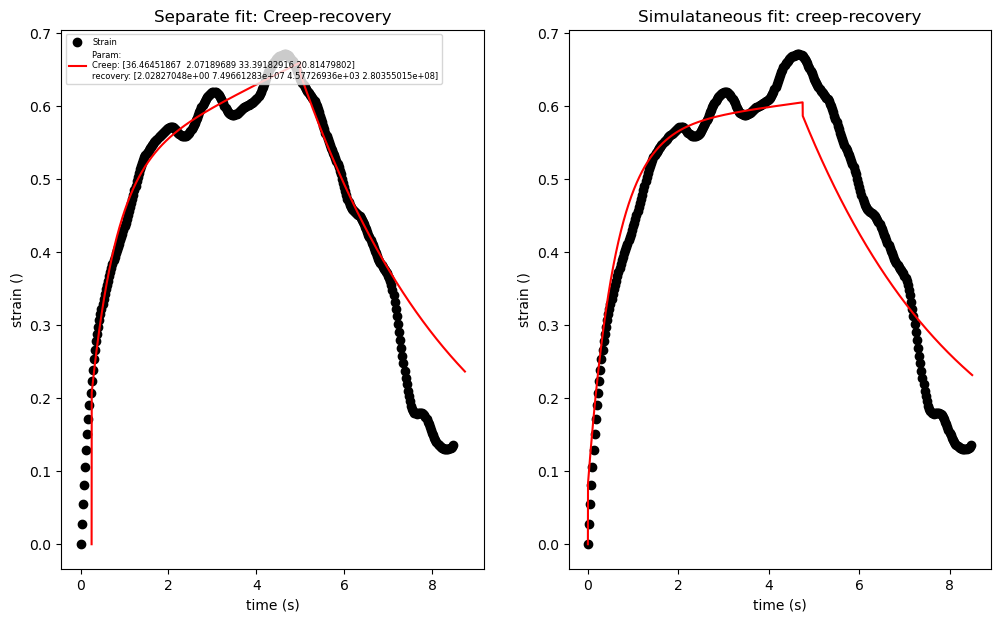

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,7))

path_track = os.path.join(root, "track_1/trackingData_2024-02-01.pickle")

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)
df_track = pd.DataFrame.from_dict(file_track)

start = 10
end = 200
helper = 350

df_track["time"] = df_track["t"]*1/40
df_track["x"] = scipy.signal.detrend(scipy.ndimage.gaussian_filter(df_track["x"],5))*1e-6*m
df_track["y"] = scipy.signal.detrend(scipy.ndimage.gaussian_filter(df_track["y"],5))*1e-6*m
df_track["x"] -= df_track["x"].min()
df_track["y"] -= df_track["y"].min()

df_track["r"] = np.sqrt(df_track["x"]**2 + df_track["y"]**2)
df_track["r"] = (df_track["r"].max() - df_track["r"])

ax[0].set_title("Separate fit: Creep-recovery")

#ax.vlines(df_track["time"].values[end], df_track["r"].min(), df_track["r"].max(), color = "blue", label = "start creep", linestyle = "dashed")
#ax.vlines(df_track["time"].values[helper], df_track["r"].min(), df_track["r"].max(), color = "blue", label = "start creep", linestyle = "dashed")

x = df_track["time"]
y = df_track["r"]/(2*radius)

current_label = label_list[-2]
xx, yy, xdata_, ydata_, label = fit_classicMicro(x,y, current_label, start, end, helper)

x_plot = x[start:helper]-x[start]
y_plot = y[start:helper]- y[start]

ax[0].scatter(xx , yy, color = "black", label = "Strain")
ax[0].plot(xdata_, ydata_, label = "Param: \nCreep: {}\nrecovery: {}".format(label[0], label[1]), color = "red")

ax[0].legend(loc = "upper left",fontsize = 6)
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("strain ()")


model = burger(x[end]-x[start], y[end]-y[start], start, end, helper)

# curve fit the combined data to the combined function
xx, yy, p = model.fit(x,y)

ax[1].plot(xx, yy, color = "red")
ax[1].scatter(x_plot, y_plot, color = "black", label = "Param: \n{}".format(*p))

ax[1].set_title("Simulataneous fit: creep-recovery")
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel("strain ()")


fig.savefig('./figures/microns.png') 

### Generalized response

#### Silicone oil

In [209]:
j = 1j

df_sub = df_col[df_col["label"] == 35]
r = np.sqrt(df_sub["x_scaled"]**2 + df_sub["y_scaled"]**2)
r = r-r[0]
t = np.linspace(1e-12,len(r)*(1/camera_rate), len(r))
force = scipy.ndimage.gaussian_filter(df_sub["force"].values,20)

area = np.pi*radius**2
stress = force/area #stress
gamma = r/(2*radius) #strain

J = gamma/stress #Creep compliance

omega = np.linspace(1/t[-1],1/t[1], 10000)

J1 = J[1]
t1 = t[1] 
t_last = t[-1]

sum = 0
for k in range(1,len(t)):
    sum += (J[k]-J[k-1])/(t[k]-t[k-1])*(np.exp(-j*omega[k]*t[k-1])-np.exp(-j*omega[k]*t[k]))

bounds = [[0, 0, 0, 0, 0, 0, 0],[np.inf, np.inf,np.inf,np.inf, np.inf,np.inf,np.inf]]
popt, pcov = curve_fit(J_t, t, J, bounds = bounds, method = "dogbox", maxfev = 1000000)

xdata_ = np.linspace(1e-12,t[-1], 100000)
ydata_ = J_t(xdata_, *popt)

coef = np.polyfit(t[-100:-75],J[-100:-75],1)
coef_2 = np.polyfit(t[1:25],J[1:25],1)

n_eta = 1/coef[0]*1e6
#n_eta = popt[0]*1e6
J0 = coef_2[1]*1e-6
#J0 = ydata[1]

g_data = G(omega, J0, n_eta, sum, t1, J1, t_last)
e_data = (g_data/(omega*j))**-1

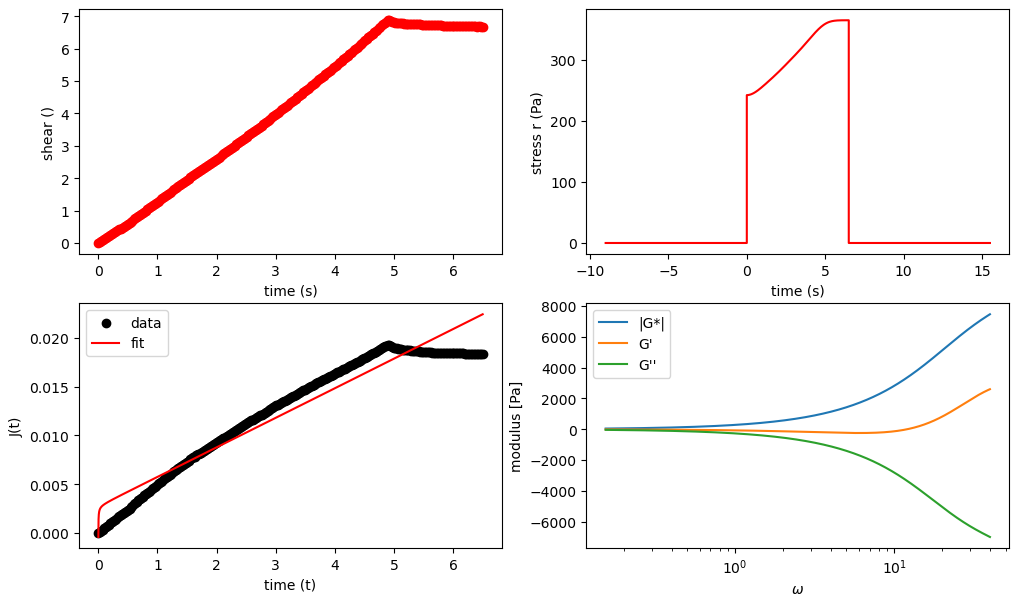

In [210]:
fig, ax  = plt.subplots(2, 2, figsize = (12,7))


ax[0,0].scatter(t,gamma, color = "red")
ax[0,0].set_xlabel("time (s)")
ax[0,0].set_ylabel(r'shear ()')

ax[0,1].plot(np.concatenate((np.arange(-9,1),t,np.arange(6.5,16.5))),np.concatenate((np.repeat(0,10),stress,np.repeat(0,10))), color = "red")
ax[0,1].set_xlabel("time (s)")
ax[0,1].set_ylabel("stress r (Pa)")


ax[1,0].scatter(t,J, label = "data", color = "black")
ax[1,0].plot(xdata_, ydata_, label = "fit", color = "red")
ax[1,0].legend()

ax[1,0].set_xlabel(r'time (t)')
ax[1,0].set_ylabel("J(t)")

ax[1,1].plot(omega, np.abs(e_data), label = "|G*|")
ax[1,1].plot(omega, np.real(e_data), label = "G'")
ax[1,1].plot(omega, -np.imag(e_data), label = "G''")

ax[1,1].set_xscale("log")
ax[1,1].set_xlabel(r'$\omega$')
ax[1,1].set_ylabel("modulus [Pa]")

ax[1,1].legend()


fig.savefig('./figures/microns_2.png') 

#### Growdex (not working)

In [16]:
class generalized_model():

    def __init__(self, J, t, omega, t1, J1, t_last):
        self.sum = 0
        self.J1 = J1
        self.t1 = t1
        self.t_last = t_last

        j = 1j
        
        for k in range(1,len(t)):
            self.sum += (J[k]-J[k-1])/(t[k]-t[k-1])*(np.exp(-j*omega[k]*t[k-1])-np.exp(-j*omega[k]*t[k]))        
        
    def G(self,omega, J0, n):
        j=1j

        return j*omega*J0 + (1-np.exp(-j*omega*self.t1))*(self.J1-J0)/self.t1 + np.exp(-j*omega*self.t_last)/n + self.sum

    def J_t(self,t, eta, a, b, c, d, e, f):
        return (t/eta) + a + b*np.tanh(c + d*np.log(t) + e*np.log(t)**2 + f*np.log(t)**3)
    


xdata_ = omega+ 1e-12
ydata_ = gen_model.G(xdata_, *popt)
e_data = (ydata/(xdata_*j))**-1
plt.plot(xdata_, ydata_)

plt.plot(xdata_, np.abs(e_data), label = "|G*|")
plt.plot(xdata_, np.real(e_data), label = "G'")
plt.plot(xdata_, -np.imag(e_data), label = "G''")

NameError: name 'omega' is not defined

In [15]:
class particle:

    def __init__(self,x,y, dt, np_steps, size, rho):

        self.s_x = x
        self.s_y = y
        self.dt = dt

        self.v_x = 0
        self.v_y = 0
        self.step = 0

        self.position_history = np.zeros((2,np_steps))
        self.position_history[0,self.step] = self.s_x
        self.position_history[1,self.step] = self.s_y

        self.prev_x = self.s_x
        self.prev_y = self.s_y

        self.size = size
        self.volume = 4/3*np.pi*(size/2)**3
        self.rho = rho

        self.m = self.rho*self.volume

        self.vis = 1

        self.eta = 1#1e-3
        self.mu = 1e-2

        self.A = 6*np.pi*self.size*self.eta
        self.B = 6*np.pi*self.size*self.mu


    def new_pos(self, f_x, f_y):
        
        self.v_x =  f_x/self.m*self.dt 
        self.s_x = self.s_x + self.v_x*self.dt #+ f_x/self.m*self.dt**2
        
        self.v_y =  f_y/self.m*self.dt
        self.s_y = self.s_y + self.v_y*self.dt #+ f_y/self.m*self.dt**2
        
        self.position_history[0,self.step] = self.s_x
        self.position_history[1,self.step] = self.s_y
        

        self.step += 1

    def new_position_drag(self, f_x, f_y):



        alpha_x = f_x*self.A/(self.B*self.dt)*np.exp(self.B*self.dt/self.A)
        alpha_y = f_y*self.A/(self.B*self.dt)*np.exp(self.B*self.dt/self.A)

        beta_x = self.prev_x - alpha_x
        beta_y = self.prev_y - alpha_y
        #print(self.prev_x, alpha_x, beta_x, np.exp(self.B*self.dt/self.A))

        self.s_x = (alpha_x + beta_x)*np.exp(self.B*self.dt/self.A) #+ f_x/self.m*self.dt**2
        self.s_y =  (alpha_y + beta_y)*np.exp(self.B*self.dt/self.A) #+ f_y/self.m*self.dt**2
        
        self.position_history[0,self.step] = self.s_x
        self.position_history[1,self.step] = self.s_y

        self.prev_x = self.s_x
        self.prev_y = self.s_y

        self.step += 1

    def add_drag(self, v):

        f_d = 3*np.pi*self.vis*self.size*self.volume

        return -f_d

    def get_position(self):
        return self.s_x,self.s_y
    
    def add_noise(self):
        self.s_x +=  np.random.normal(0,1e-7)
        self.s_y +=  np.random.normal(0,1e-7)

    def get_history(self):
        return self.position_history
    

class stateSpace_bead():

    def __init__(self, x_coord, y_coord, B, dBx, dBy, M, H, mu_0):
        self.B_field = B
        self.dBx_field = dBx
        self.dBy_field = dBy

        self.M_slope = M
        self.H_slope = H
        self.x_sim = x_coord
        self.y_sim = y_coord

        self.mu_0 = mu_0
    
    def find_force(self, x, y, radius):
        
        x_idx = np.argmin(np.abs((self.x_sim-x)))
        y_idx = np.argmin(np.abs((self.y_sim-y)))
        
        B_current = self.B_field[y_idx, x_idx]
        H_current = B_current/self.mu_0

        mu_idx = np.argmin(np.abs(self.H_slope - H_current))
        mu_current = self.M_slope[mu_idx]
        
        F_field_x = 4/3*np.pi*(radius)**3*mu_current*self.dBx_field[y_idx,x_idx] #Estimate
        F_field_y = 4/3*np.pi*(radius)**3*mu_current*self.dBy_field[y_idx,x_idx] #Estimate


        force =  np.sqrt((F_field_x)**2 + (F_field_y)**2)


        return force, -F_field_x, F_field_y

(0.0026535897435897436, 0.0033464102564102565)

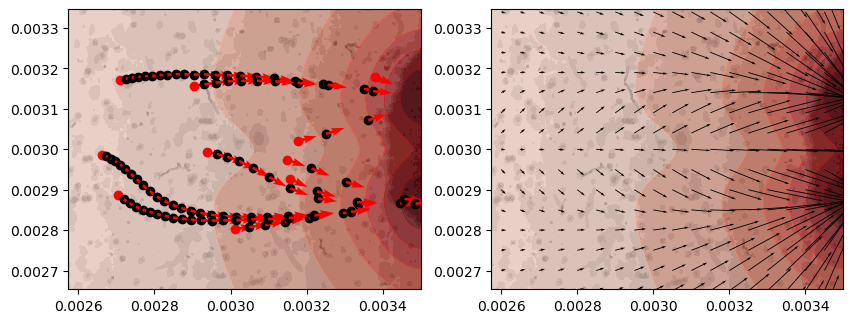

In [11]:
fig = plt.figure(figsize = (10,8))

ax1 = fig.add_subplot(2,2,1)

ax1.contourf(xx__, yy__, test_frame, alpha = 1, cmap="binary")
CS = ax1.contourf(x_coord, y_coord, filtered, alpha = 0.5, cmap = "Reds")
#ax2.quiver(X1[::phase, ::phase], Y1[::phase, ::phase], dBy[::phase,::phase], -dBx[::phase,::phase], angles = "xy") #dBy[::phase,::phase],dBx[::phase,::phase]


model_bead = stateSpace_bead(x_coord, y_coord, BB, dBx, dBy, M_mag, xdata, mu_0)

steps = 100
for i in range(10):
    
    x_start = np.random.uniform(low=start_w*1.025, high=end_w*0.975)

    y_start = np.random.uniform(low=start_h*1.025, high=end_h*0.975)

    bead = particle(x_start,y_start, 1/40000, steps, radius, rho)

    ax1.scatter(bead.s_x, bead.s_y, color = "red")

    for i in range(steps):
        
        force, force_x, force_y = model_bead.find_force(bead.s_x, bead.s_y, bead.size)
        ax1.quiver(bead.s_x, bead.s_y, force_y, force_x, color='r', angles = "xy")
        bead.new_pos(force_y, force_x)
        
        if ((bead.s_y>end_h) & (bead.s_x<start_w) & (bead.s_x>end_w)):
            break

        ax1.scatter(bead.s_x, bead.s_y , color = "black")
        
ax1.quiver(bead.s_x, bead.s_y, force_y, force_x, color='r', angles = "xy")
ax1.set_xlim(start_w, end_w)
ax1.set_ylim(start_h, end_h)

ax2 = fig.add_subplot(2,2,2)

ax2.contourf(xx__, yy__, test_frame, alpha = 1, cmap="binary")
CS = ax2.contourf(x_coord, y_coord, filtered, alpha = 0.5, cmap = "Reds")
ax2.quiver(X1[::phase, ::phase], Y1[::phase, ::phase], dBy[::phase,::phase], -dBx[::phase,::phase], angles = "xy") #dBy[::phase,::phase],dBx[::phase,::phase]
ax2.set_xlim([start_w,end_w])
ax2.set_ylim([start_h,end_h])


(0.0026535897435897436, 0.0033464102564102565)

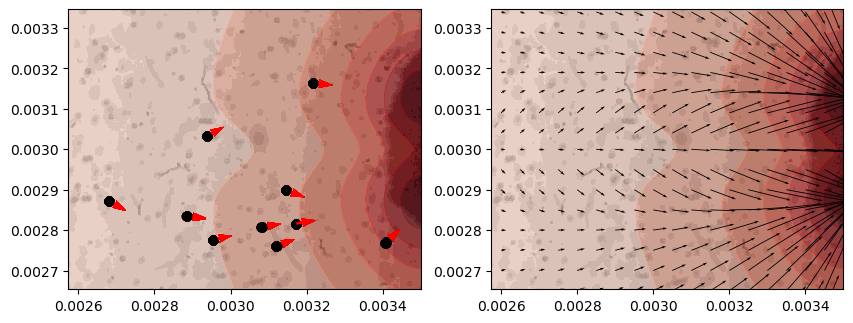

In [18]:
fig = plt.figure(figsize = (10,8))

ax1 = fig.add_subplot(2,2,1)

ax1.contourf(xx__, yy__, test_frame, alpha = 1, cmap="binary")
CS = ax1.contourf(x_coord, y_coord, filtered, alpha = 0.5, cmap = "Reds")
#ax2.quiver(X1[::phase, ::phase], Y1[::phase, ::phase], dBy[::phase,::phase], -dBx[::phase,::phase], angles = "xy") #dBy[::phase,::phase],dBx[::phase,::phase]


model_bead = stateSpace_bead(x_coord, y_coord, BB, dBx, dBy, M_mag, xdata, mu_0)

steps = 100
for i in range(10):
    
    x_start = np.random.uniform(low=start_w*1.025, high=end_w*0.975)

    y_start = np.random.uniform(low=start_h*1.025, high=end_h*0.975)

    bead = particle(x_start,y_start, 1/4000, steps, radius, rho)

    ax1.scatter(bead.s_x, bead.s_y, color = "red")

    for i in range(steps):
        force, force_x, force_y = model_bead.find_force(bead.s_x, bead.s_y, bead.size)
        ax1.quiver(bead.s_x, bead.s_y, force_y, force_x, color='r', angles = "xy")

        bead.new_position_drag(force_y, force_x)
        
        if ((bead.s_y>end_h) & (bead.s_x<start_w) & (bead.s_x>end_w)& (bead.s_y<start_h)):
            print("breaking", i)
            break

        ax1.scatter(bead.s_x, bead.s_y , color = "black")

ax1.quiver(bead.s_x, bead.s_y, force_y, force_x, color='r', angles = "xy")
ax1.set_xlim(start_w, end_w)
ax1.set_ylim(start_h, end_h)

ax2 = fig.add_subplot(2,2,2)

ax2.contourf(xx__, yy__, test_frame, alpha = 1, cmap="binary")
CS = ax2.contourf(x_coord, y_coord, filtered, alpha = 0.5, cmap = "Reds")
ax2.quiver(X1[::phase, ::phase], Y1[::phase, ::phase], dBy[::phase,::phase], -dBx[::phase,::phase], angles = "xy") #dBy[::phase,::phase],dBx[::phase,::phase]
ax2.set_xlim([start_w,end_w])
ax2.set_ylim([start_h,end_h])


### Assume that the change of area follow 

$\rightarrow$ Did not work because the offseted z-level gets blurred and area migth even increase when moving out of the cross-sectional area

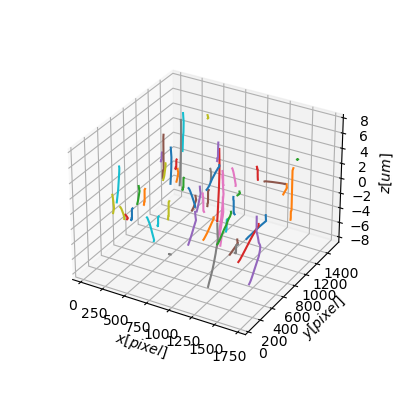

In [27]:
def radiusFunc(t, r, omega, shift):
    return r*np.cos(omega*t-shift)

ax = plt.figure(figsize=(15, 5)).add_subplot(projection='3d')
helper = np.zeros(df_mg["label"].nunique())
idx = 0
for i in df_mg.groupby(["label"]):
    tags = i[0]
    data = i[1]

    data["radius"] *= m

    x_test = np.linspace(0, 1/camera_rate,data["radius"].shape[0])

    try: 
        p, p_ = curve_fit(radiusFunc, x_test, data["radius"], maxfev = 1000)
    except:
        idx += 1
        continue

    y_test_coord = p[0]*np.sin(p[1]*x_test-p[2])
    #plt.plot(x_test, y_test_coord, color = "red")
    y_movement = (y_test_coord[-1] - y_test_coord[0])
    if y_movement < 10:
        ax.plot(data["x"], data["y"],(y_test_coord))
        helper[idx] = np.abs(y_movement)
    idx += 1


ax.set(xlabel=(r' $x [pixel]$'), ylabel=(r'$y [pixel]$'), zlabel=(r'$z [um]$'))
ax.set_box_aspect(aspect=None, zoom=0.8)



### Radial profile

This is meant for DIC images with diffraction pattern, we dont have one. Especially reflections from particle surface make the estimate unstable and difficult to compute. 

In [29]:
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile, nr


test_pic = frame.copy()

start_point = (560,600)
end_point = (840,875)

pros_img = frame[start_point[1]:end_point[1], start_point[0]:end_point[0]].copy()
center = np.array((int((end_point[0]-start_point[0])/2), int((end_point[1]-start_point[1])/2)))

rad_prof, n_bin = radial_profile(pros_img[:,:,0], center)
rad_grad = np.gradient(rad_prof)
rad_cont = np.argmax(np.gradient(rad_prof))


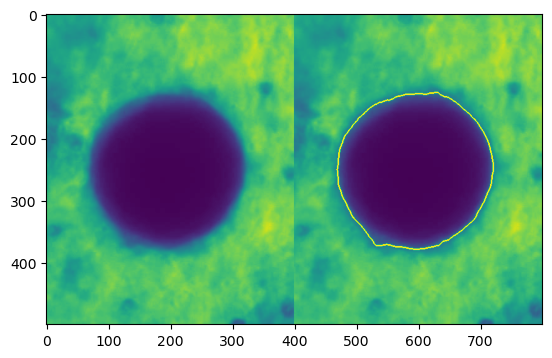

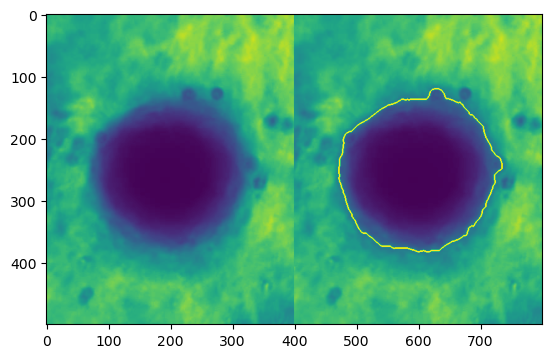

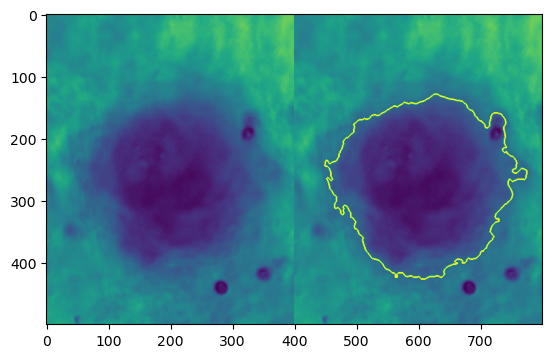

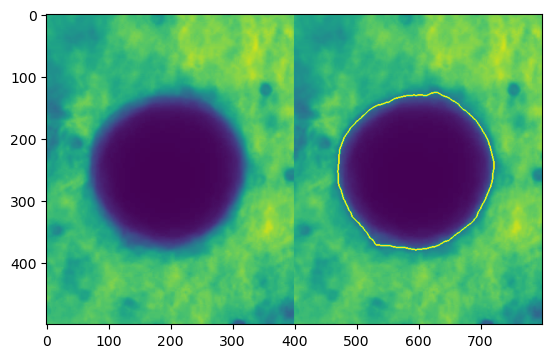

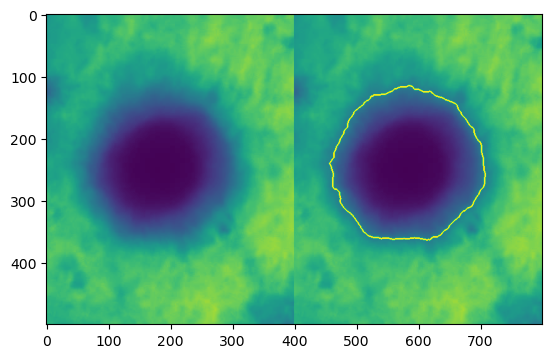

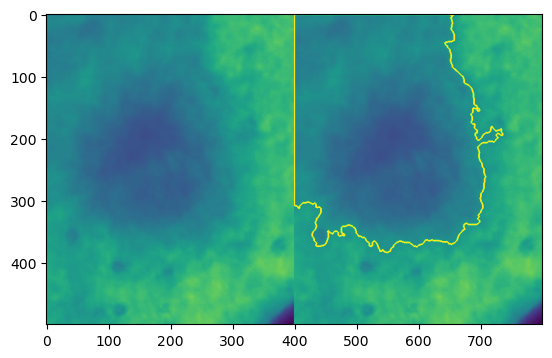

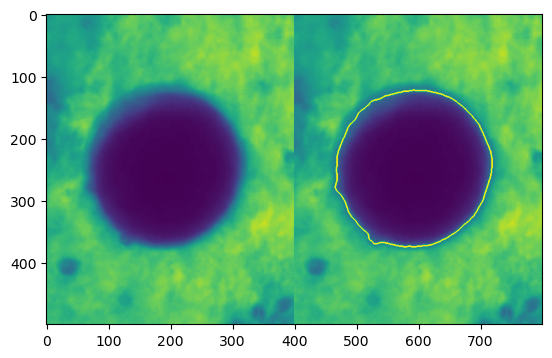

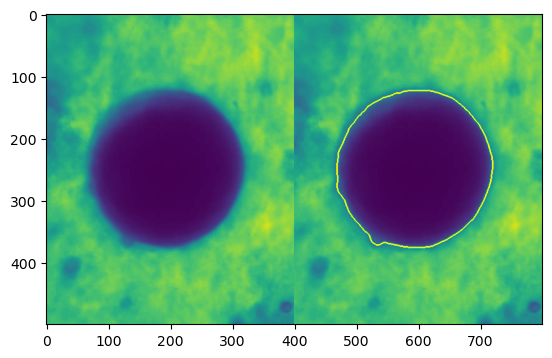

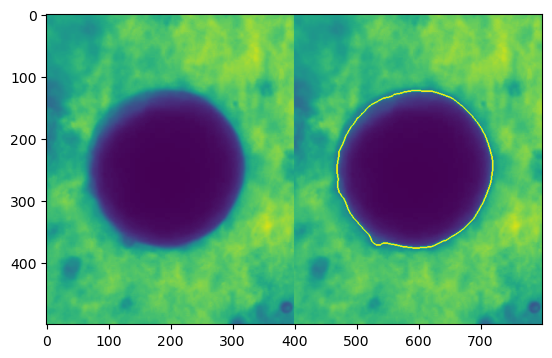

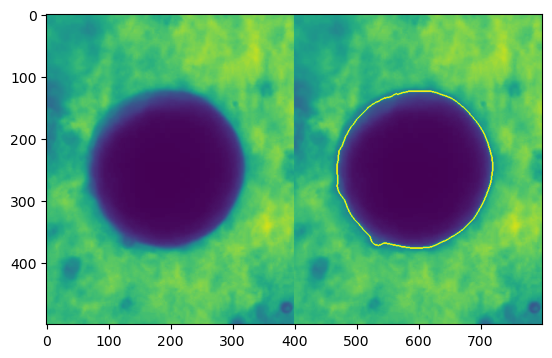

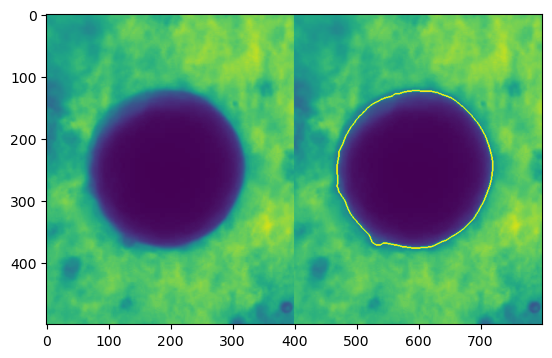

In [35]:
start_point = (1000,1400)
end_point = (1400,1900)

center = np.array((int((end_point[0]-start_point[0])/2), int((end_point[1]-start_point[1])/2)))
 
dict_areas = {"radius": [], "contours": [], "center":  [], "lap": []}

#Download frame for visualization glitter
path_vid = ["E:/demoData/swipes/recording_scan.avi"]
cap = cv2.VideoCapture(path_vid[0])
num = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    num += 1
    if num == 3000:
        break
    if (ret==True):
        #frame = cv2.flip(frame,0)
        pros_img = frame[start_point[1]:end_point[1], start_point[0]:end_point[0]].copy()
        frameD = pros_img[:,:,0].copy()

        blur = cv2.GaussianBlur(frameD,(5,5),0)
        ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        contours, hierarchy = cv2.findContours(255-thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if len(contours) != 0:
            # draw in blue the contours that were founded

            dict_areas["lap"].append(cv2.Laplacian(frameD, cv2.CV_64F).var())
            
            c = max(contours, key = cv2.contourArea)
            (x,y),radius = cv2.minEnclosingCircle(c)
            dict_areas["radius"].append(radius)

            c_plot = c.copy()

            c[:,0,0] -= int(x)
            c[:,0,1] -= int(y)
            
            dict_areas["contours"].append(c)
            dict_areas["center"].append(np.array((x,y)))

            # show the images
            if num%40==0:
                cv2.drawContours(frameD, c_plot, -1, 255, 2)
                plt.imshow(np.hstack([pros_img[:,:,0], frameD]))
                plt.show()
    else: 
        continue

dict_areas["radius"] = np.array(dict_areas["radius"])
dict_areas["lap"] = np.array(dict_areas["lap"])

laplace = dict_areas["lap"]
laplace = scipy.ndimage.gaussian_filter1d(laplace[laplace.shape[0]//2:],10)
laplace[np.isnan(laplace)] = -np.inf

lap_max = np.argmax(laplace)


In [40]:
radius_w = np.array(dict_areas["radius"])
radius_offset = radius_w-radius_w[int(lap_max)]

#plt.plot(radius_offset)
peak_idx, _ = scipy.signal.find_peaks(radius_offset, width = 5, height=5)
#plt.scatter(peak_idx, radius_offset[peak_idx], color = "red")

top_idx = radius_offset[peak_idx].argsort()[-2]
top_value = radius_offset[peak_idx][top_idx]

cut_idx = np.where(radius_offset > top_value)[0][0]
start_cut_idx = np.where(radius_offset == top_value)[0][0]
radius_single = radius_w[start_cut_idx:cut_idx] - radius_w[int(lap_max)]

k, b = np.polyfit(np.arange(0,30), radius_single[:30],1 )
k *= (-1)

focus_level = radius_w[int(lap_max)]

#plt.plot(radius_single)
#plt.plot(-k*np.arange(0,30)+b)

print("Scanning speed is ", k, "\nand focus level is", focus_level )




Scanning speed is  1.238612119613156 
and focus level is 135.69325256347656


In [41]:
num_points = 25
levels = []
#Download frame for visualization glitter
path_vid = ["E:/demoData/swipes/recording.avi"]
cap = cv2.VideoCapture(path_vid[0])
num = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    num += 1
    if num == 1000:
        break
    if (ret==True) & (num%5 == 0):
        #frame = cv2.flip(frame,0)
        pros_img = frame[start_point[1]:end_point[1], start_point[0]:end_point[0]].copy()
        frameD = pros_img[:,:,0].copy()

        blur = cv2.GaussianBlur(frameD,(5,5),0)
        ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        contours, hierarchy = cv2.findContours(255-thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if len(contours) != 0:
            # draw in blue the contours that were founded
            
            c = max(contours, key = cv2.contourArea)
            (x,y),radius = cv2.minEnclosingCircle(c)

            idx = np.linspace(0,c.shape[0]-1, num_points, dtype = int)
            x_test = c[idx,0,0] - int(x)
            y_test = c[idx,0,1] - int(y)
            
            points_contour = np.zeros(len(dict_areas["contours"]))
            points_center = np.zeros(len(dict_areas["contours"]))

            
            for i in range(len(dict_areas["contours"])):
                probed_cnt = dict_areas["contours"][i]
                idx_probe = np.linspace(0,probed_cnt.shape[0]-1, num_points, dtype = int)
                points_contour[i] = np.sum(np.abs(probed_cnt[idx_probe,0,0]-x_test)+np.abs(probed_cnt[idx_probe,0,1]-y_test))

            match = np.argmin(points_contour)

            levels.append(match)
    else: 
        continue


levels = np.array(levels)


In [49]:
len(levels)

199

In [50]:
len(dict_areas["radius"])

441

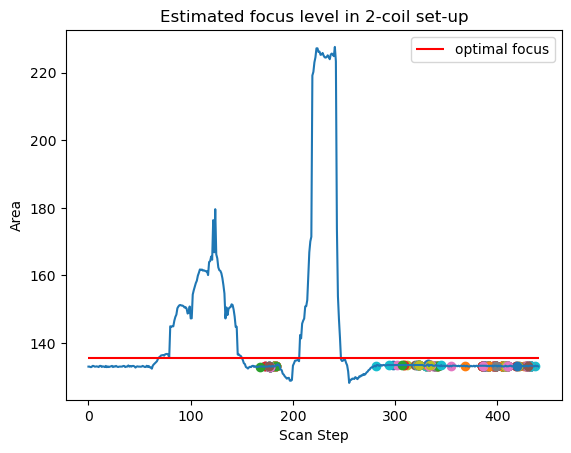

In [62]:
plt.plot(np.arange(0, len(dict_areas["radius"])), np.array(dict_areas["radius"]), label = None)

for i in range( len(levels)):
    plt.scatter(levels[i], dict_areas["radius"][levels[i]], label = None)

plt.hlines(radius_w[int(lap_max)], 0, len(dict_areas["radius"]), label = "optimal focus", color = "red")

plt.xlabel("Scan Step")
plt.ylabel("Area")
plt.title("Estimated focus level in 2-coil set-up")
plt.legend()

